In [132]:
#import required libraries
import sys
import os

from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

In [62]:
#function to read prediction data file. Generally expeceted to have format of label,probability score
def read_pred_file(fl_name):
    df = pd.read_csv( fl_name)
    col1 = df.columns[0]
    print("[%d] records loaded from File[%s] " % (df[col1].count(),fl_name))
    
    return df

In [170]:
#set key variables.
ddir = '/disk1/data1/data/models/inception/'
#model_name = 'incep_v3_he_wce_w25.cpkt'
model_name = 'incep_v3_he_da_wce10.cpkt'
steps = '79000'
pred_df_fl = ddir + model_name + '-' + steps + '_df.csv'



In [193]:
#scan model nohup output file for key data points.
tmp = '/tmp/'
model_log_fl = 'kaggle_pretrain.out'
modelrun_df_fl = 'modelrun_df.csv'

def run_analysis():
    cmd = "grep 'step ' " + tmp + model_log_fl \
                + " | cut -d ' ' -f4,5,10 | sed  's/ loss=//g' | sed 's/ accu\[/,/g' | sed 's/\]//g' > " \
                + tmp + modelrun_df_fl
    print("Executing command - [{}]".format(cmd))
    os.system(cmd)
    modelrun_df = pd.read_csv( tmp + modelrun_df_fl, names=['step','loss','accu'])
    #print(df.head())
    
    return modelrun_df

def get_analysis_graph(modelrun_df):
    plt.style.use('seaborn-whitegrid')
    #fig = plt.figure()
    #ax = plt.axes()
    #x = np.linspace(0, 1000, 100000)
    min = modelrun_df['loss'].min()
    max = modelrun_df['loss'].max()
    print("Min loss [{}] Max loss [{}]".format(min,max))
    print("Min accu [{}] Max accu [{}]".format(modelrun_df['accu'].min(),modelrun_df['accu'].max()))
    #plt.plot(modelrun_df['step'],modelrun_df['accu'],color='blue');
    #plt.plot(modelrun_df['step'],(modelrun_df['loss']-min)/max,color='green');
    #print(ax.plot(modelrun_df['step'],modelrun_df['loss']))

#modelrun_df = run_analysis()
get_analysis_graph(modelrun_df)

Min loss [357.4] Max loss [405.1]
Min accu [0.00035] Max accu [0.11198]


In [162]:
#load data
pred_df = read_pred_file(pred_df_fl)

[104857600] records loaded from File[/disk1/data1/data/models/inception/incep_v3_he_da_wce.cpkt-77000_df.csv] 


In [171]:
#check data
print("Data columns: ",pred_df.columns)
print(pred_df.head())

Data columns:  Index(['label', 'prob', 'pred'], dtype='object')
   label      prob  pred
0    0.0  0.468994   0.0
1    0.0  0.427706   0.0
2    0.0  0.384649   0.0
3    0.0  0.435321   0.0
4    0.0  0.400247   0.0


In [172]:
#calculate ROC specific details and plot the grpah
fpr, tpr, _ = metrics.roc_curve(pred_df.label,  pred_df.prob)
auc = metrics.roc_auc_score(pred_df.label,  pred_df.prob)
print("AUC - [%f]" % (auc))

AUC - [0.500472]


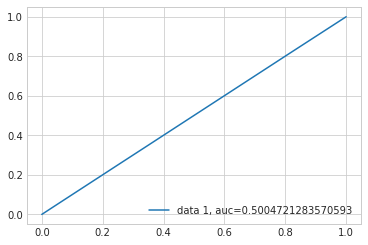

In [173]:
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [174]:
#Prepare predcition for confusion matrix. create prediction using optimal threshold, in our case threshold is .5
threshold = auc
#threshold = 0.1
pred_df['pred'] = pred_df.prob.apply(lambda x: 0. if x < threshold else 1.)

In [175]:
#print confusion matrix.
total = pred_df.label.count()

tot_1s = pred_df[(pred_df.label == 1.)]['label'].count()
tot_0s = pred_df[(pred_df.label == 0.)]['label'].count()
tp = pred_df[(pred_df.label == pred_df.pred) & (pred_df.label == 1.)]['label'].count()
tn = pred_df[(pred_df.label == pred_df.pred) & (pred_df.label == 0.)]['label'].count()
fp = pred_df[(pred_df.label == 0.) & (pred_df.pred == 1.)]['label'].count()
fn = pred_df[(pred_df.label == 1.) & (pred_df.pred == 0.)]['label'].count()
#print(" tp 1's : ",/tot_1s)
#print(" tp 0's : ",pred_df[(pred_df.label == pred_df.pred) & (pred_df.label == 0.)]['label'].count()/tot_0s)

In [176]:
'''------not weigthed CE-------
 tp:  200  fp:  13432
 fn:  1080852  tn:  73354412
 Total labels 1's:  1081052  Total labels 0's:  73367844
 % labels 1's:  0.014520725733797315  % labels 0's:  0.9854792742662026
 Precision:  0.014671361502347418
 Recall:  0.00018500497663387146
 F1 score:  0.00036540225307029245
  ----------w=10---------
 tp:  67  fp:  4477
 fn:  1080985  tn:  73363367
 Total labels 1's:  1081052  Total labels 0's:  73367844
 % labels 1's:  0.014520725733797315  % labels 0's:  0.9854792742662026
 Precision:  0.014744718309859154
 Recall:  6.197666717234694e-05
 F1 score:  0.00012343450049558032
 ----------w=25---------
  tp:  9087  fp:  617985
 fn:  1071965  tn:  72749859
 Total labels 1's:  1081052  Total labels 0's:  73367844
 % labels 1's:  0.014520725733797315  % labels 0's:  0.9854792742662026
 Precision:  0.014491158909981629
 Recall:  0.00840570111335995
 F1 score:  0.01063974278213994
 ----------w=50---------
 tp:  26411  fp:  1791189
 fn:  1054641  tn:  71576655
 Total labels 1's:  1081052  Total labels 0's:  73367844
 % labels 1's:  0.014520725733797315  % labels 0's:  0.9854792742662026
 Precision:  0.014530699823943663
 Recall:  0.024430832189385895
 F1 score:  0.018222953290012046
 ----------w=75---------
  tp:  55304  fp:  3748024
 fn:  1025748  tn:  69619820
 Total labels 1's:  1081052  Total labels 0's:  73367844
 % labels 1's:  0.014520725733797315  % labels 0's:  0.9854792742662026
 Precision:  0.014540949400104329
 Recall:  0.051157576138798136
 F1 score:  0.022645248731671164
----------w=100---------
 tp:  98815  fp:  6703553
 fn:  982237  tn:  66664291
 Total labels 1's:  1081052  Total labels 0's:  73367844
 % labels 1's:  0.014520725733797315  % labels 0's:  0.9854792742662026
 Precision:  0.014526558986517637
 Recall:  0.09140633383038003
 F1 score:  0.02506906900812084
 ----------Xaviers initialization---------
 tp:  507  fp:  69893
 fn:  760209  tn:  104026991
 Total labels 1's:  760716  Total labels 0's:  104096884
 % labels 1's:  0.007254753112792969  % labels 0's:  0.992745246887207
 Precision:  0.007201704545454546
 Recall:  0.0006664773713185998
 F1 score:  0.0012200462991928925
'''
print(" tp: ",tp," fp: ",fp)
print(" fn: ",fn," tn: ",tn)
print(" Total labels 1's: ",tot_1s," Total labels 0's: ",tot_0s)
print(" % labels 1's: ",tot_1s/total," % labels 0's: ",tot_0s/total)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print(" Precision: ",precision)
print(" Recall: ",recall)
print(" F1 score: ",2*precision*recall/(precision+recall))


 tp:  6678  fp:  57322
 fn:  10762611  tn:  94030989
 Total labels 1's:  10769289  Total labels 0's:  94088311
 % labels 1's:  0.10270394325256348  % labels 0's:  0.8972960567474365
 Precision:  0.10434375
 Recall:  0.0006200966470488442
 F1 score:  0.0012328665837309427


In [117]:
print(pred_df.head())
print(pred_df.pred.unique())
print(pred_df.label.unique())

   label      prob  pred
0    0.0  0.000703   0.0
1    0.0  0.000584   0.0
2    0.0  0.000564   0.0
3    0.0  0.000389   0.0
4    0.0  0.000569   0.0
[0. 1.]
[0. 1.]


In [177]:
fp_df = pred_df[(pred_df.label == 0.) & (pred_df.pred == 1.)]
fp_df.prob.describe()

count    57322.000000
mean         0.503562
std          0.002275
min          0.501010
25%          0.501491
50%          0.503115
75%          0.505257
max          0.508242
Name: prob, dtype: float64

In [178]:
fn_df = pred_df[(pred_df.label == 1.) & (pred_df.pred == 0.)]
fn_df.prob.describe()

count    1.076261e+07
mean     4.304396e-01
std      2.085227e-02
min      3.545884e-01
25%      4.161924e-01
50%      4.302675e-01
75%      4.444484e-01
max      5.003940e-01
Name: prob, dtype: float64

In [179]:
tn_df = pred_df[(pred_df.label == pred_df.pred) & (pred_df.label == 0.)]
tn_df.prob.describe()


count    9.403099e+07
mean     4.304024e-01
std      2.085085e-02
min      3.545884e-01
25%      4.161541e-01
50%      4.302505e-01
75%      4.444186e-01
max      5.003940e-01
Name: prob, dtype: float64

In [180]:
tp_df = pred_df[(pred_df.label == pred_df.pred) & (pred_df.label == 1.)]
tp_df.prob.describe()

count    6678.000000
mean        0.503564
std         0.002260
min         0.501010
25%         0.501491
50%         0.503205
75%         0.505257
max         0.508242
Name: prob, dtype: float64

In [ ]:
print(tn_df.head())
print(fn_df.head())
print(tn_df.prob.describe())
print(fn_df.prob.describe())